In [ ]:
import torch
import json
import pandas as pd

from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
import torch.nn as nn
from sklearn.model_selection import train_test_split
from transformers import BertTokenizerFast, BertModel

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
device

device(type='cpu')

In [ ]:
import requests
import time

# Function to fetch the list of problems with metadata
def fetch_problems_metadata(skip=0, limit=100):
    url = "https://leetcode.com/graphql"
    headers = {"Content-Type": "application/json"}
    query = """
    {
      problemsetQuestionListV2(
        limit: %d,
        skip: %d
      ) {
        questions {
          title
          titleSlug
          difficulty
          topicTags {
            name
          }
        }
      }
    }
    """ % (limit, skip)
    response = requests.post(url, json={"query": query}, headers=headers)
    if response.status_code != 200:
        print(f"HTTP Error: {response.status_code}")
        return None
    data = response.json()
    if "errors" in data:
        print(f"GraphQL Errors: {data['errors']}")
        return None
    return data['data']['problemsetQuestionListV2']['questions']

# Function to fetch problem description using titleSlug
def fetch_problem_description(title_slug):
    url = "https://leetcode.com/graphql"
    headers = {"Content-Type": "application/json"}
    query = """
    {
      question(titleSlug: "%s") {
        content
      }
    }
    """ % title_slug
    response = requests.post(url, json={"query": query}, headers=headers)
    if response.status_code != 200:
        print(f"HTTP Error: {response.status_code}")
        return None
    data = response.json()
    if "errors" in data:
        print(f"GraphQL Errors: {data['errors']}")
        return None
    return data

# Main function to fetch all problems
def fetch_all_problems(skip=0, limit=100):
    all_problems = []

    while True:
        print(f"Fetching problems with skip={skip}...")
        problems = fetch_problems_metadata(skip=skip, limit=limit)
        if not problems:
            break
        for problem in problems:
          try:
              # Try block starts here
              print(f"Fetching description for {problem['title']}...")
              description_data = fetch_problem_description(problem['titleSlug'])

              if description_data:
                  # Ensure 'data' and 'question' keys exist before accessing 'content'
                  description = description_data.get('data', {}).get('question', {}).get('content', "")
                  all_problems.append({
                      "title": problem['title'],
                      "description": description,
                      "difficulty": problem['difficulty'],
                      "topics": [tag['name'] for tag in problem['topicTags']]
                  })

          except Exception as e:
              # Catch block logs the error and skips to the next problem
              print(f"Error fetching data for {problem['title']}: {e}")
          finally:
              # Politeness: Always sleep between iterations, even if there’s an error
              time.sleep(1)
        skip += limit
        break

    return all_problems

# Fetch and save all problems
all_problems = fetch_all_problems(skip=2618, limit = 4)

# Save results to a JSON file
with open("leetcode_problems.json", "w") as f:
    json.dump(all_problems, f, indent=2)

print("Data saved to leetcode_problems.json")

Data saved to leetcode_problems.json


In [ ]:
# Read JSON data from a file
with open("leetcode_problems.json", "r") as file:
    data = json.load(file)

# Filter out elements with "description": null
filtered_data = [item for item in data if item["description"] is not None]

# Save the filtered data back to a new JSON file
with open("filtered_out_premium_leetcode_problems.json", "w") as file:
    json.dump(filtered_data, file, indent=2)

print(f"Filtered data saved to 'filtered_leetcode_problems.json'")


Filtered data saved to 'filtered_leetcode_problems.json'


In [ ]:
# Load JSON file directly into a DataFrame
df = pd.read_json("refined_leetcode_problems.json")
# Display the DataFrame
df


,title,description,difficulty,topics
0,Two Sum,<p>Given an array of integers <code>nums</code...,EASY,"[Array, Hash Table]"
1,Add Two Numbers,<p>You are given two <strong>non-empty</strong...,MEDIUM,"[Linked List, Math, Recursion]"
2,Longest Substring Without Repeating Characters,"<p>Given a string <code>s</code>, find the len...",MEDIUM,"[Hash Table, String, Sliding Window]"
3,Median of Two Sorted Arrays,<p>Given two sorted arrays <code>nums1</code> ...,HARD,"[Array, Binary Search, Divide and Conquer]"
4,Longest Palindromic Substring,"<p>Given a string <code>s</code>, return <em>t...",MEDIUM,"[Two Pointers, String, Dynamic Programming]"
...,...,...,...,...
2679,Count Connected Components in LCM Graph,<p>You are given an array of integers <code>nu...,HARD,"[Array, Hash Table, Math, Union Find, Number T..."
2680,Transformed Array,<p>You are given an integer array <code>nums</...,EASY,"[Array, Simulation]"
2681,Maximum Area Rectangle With Point Constraints I,<p>You are given an array <code>points</code> ...,MEDIUM,"[Array, Math, Binary Indexed Tree, Segment Tre..."
2682,Maximum Subarray Sum With Length Divisible by K,<p>You are given an array of integers <code>nu...,MEDIUM,"[Array, Hash Table, Prefix Sum]"


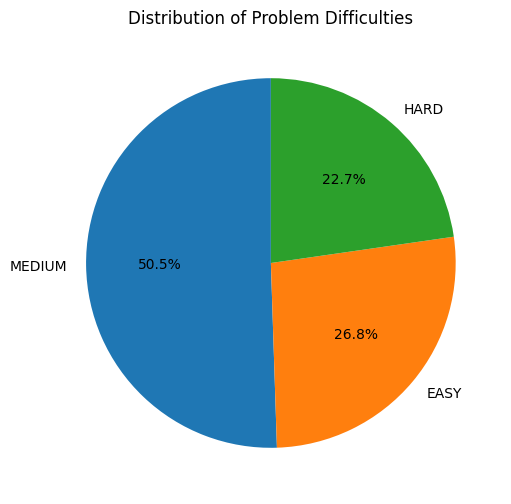

In [ ]:
# @title Distribution of Problem Difficulties

import matplotlib.pyplot as plt

difficulty_counts = df['difficulty'].value_counts()

plt.figure(figsize=(6, 6))
plt.pie(difficulty_counts, labels=difficulty_counts.index, autopct='%1.1f%%', startangle=90)
_ = plt.title('Distribution of Problem Difficulties')


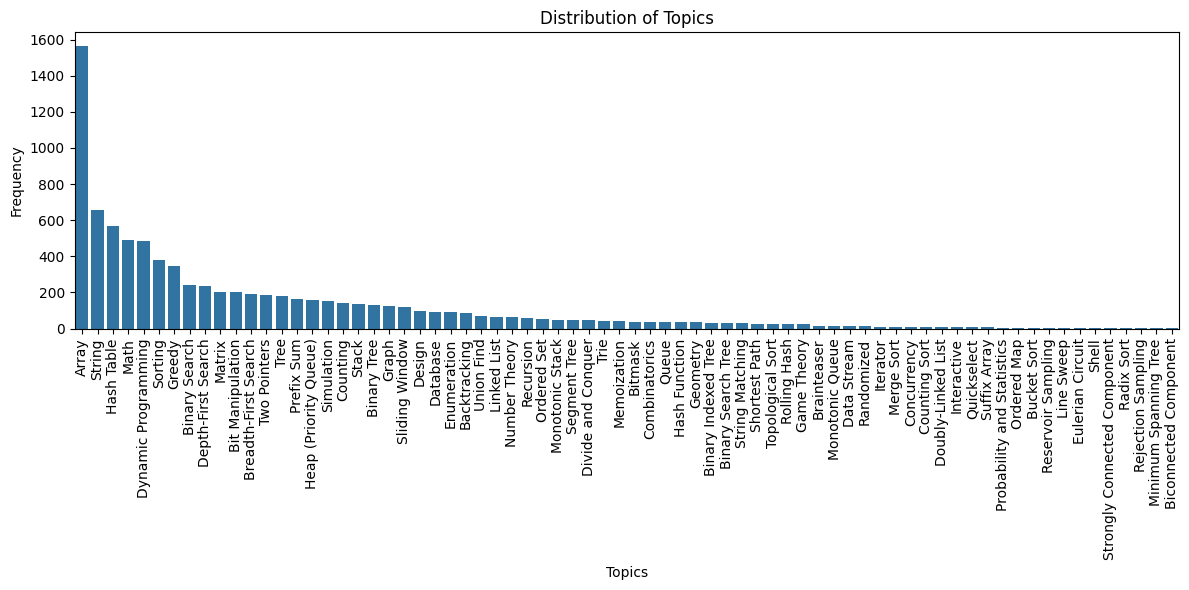

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Assuming 'df' is your DataFrame and 'topics' is the column with lists of topics
all_topics = [topic for topic_list in df['topics'] for topic in topic_list]
topic_counts = pd.Series(all_topics).value_counts()

# Create the plot
plt.figure(figsize=(12, 6))  # Adjust figure size as needed
sns.barplot(x=topic_counts.index, y=topic_counts.values)
plt.xticks(rotation=90)  # Rotate x-axis labels for readability
plt.title('Distribution of Topics')
plt.xlabel('Topics')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

In [ ]:
# Encoding maps
difficulty_map = {"EASY": 0, "MEDIUM": 1, "HARD": 2}

# Suppose df['topics'] is a column of lists, e.g. ["Array", "Hash Table"]
unique_topics = sorted(set(t for topics_list in df['topics'] for t in topics_list))
topic_to_idx = {topic: i for i, topic in enumerate(unique_topics)}

# Preprocess the difficulty column
df['difficulty_encoded'] = df['difficulty'].map(difficulty_map)

# At this point:
# df['description'] : str
# df['difficulty_encoded'] : int
# df['topics'] : list of strings

# Split the DataFrame into train and validation sets
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

In [ ]:
train_df

,title,description,difficulty,topics,difficulty_encoded
57,Length of Last Word,<p>Given a string <code>s</code> consisting of...,EASY,[String],0
695,Loud and Rich,<p>There is a group of <code>n</code> people l...,MEDIUM,"[Array, Depth-First Search, Graph, Topological...",1
2168,Modify Graph Edge Weights,<p>You are given an <strong>undirected weighte...,HARD,"[Graph, Heap (Priority Queue), Shortest Path]",2
229,Sliding Window Maximum,<p>You are given an array of integers&nbsp;<co...,HARD,"[Array, Queue, Sliding Window, Heap (Priority ...",2
1378,Where Will the Ball Fall,<p>You have a 2-D <code>grid</code> of size <c...,MEDIUM,"[Array, Matrix, Simulation]",1
...,...,...,...,...,...
1638,Partition Array Into Two Arrays to Minimize Su...,<p>You are given an integer array <code>nums</...,HARD,"[Array, Two Pointers, Binary Search, Dynamic P...",2
1095,Construct Target Array With Multiple Sums,<p>You are given an array <code>target</code> ...,HARD,"[Array, Heap (Priority Queue)]",2
1130,Capital Gain/Loss,<p>Table: <code>Stocks</code></p>\n\n<pre>\n+-...,MEDIUM,[Database],1
1294,Throne Inheritance,"<p>A kingdom consists of a king, his children,...",MEDIUM,"[Hash Table, Tree, Depth-First Search, Design]",1


In [ ]:
val_df

,title,description,difficulty,topics,difficulty_encoded
2164,Array Wrapper,<p>Create a class&nbsp;<code>ArrayWrapper</cod...,EASY,"[Array, String, Design, Math, Dynamic Programm...",0
1910,Minimum Hours of Training to Win a Competition,"<p>You are entering a competition, and are giv...",EASY,"[Array, Greedy]",0
1511,Substrings of Size Three with Distinct Characters,<p>A string is <strong>good</strong> if there ...,EASY,"[Hash Table, String, Sliding Window, Counting]",0
1027,Palindrome Partitioning III,<p>You are given a string <code>s</code> conta...,HARD,"[String, Dynamic Programming]",2
211,Maximal Square,<p>Given an <code>m x n</code> binary <code>ma...,MEDIUM,"[Array, Dynamic Programming, Matrix]",1
...,...,...,...,...,...
208,The Skyline Problem,<p>A city&#39;s <strong>skyline</strong> is th...,HARD,"[Array, Divide and Conquer, Binary Indexed Tre...",2
1767,Find All K-Distant Indices in an Array,<p>You are given a <strong>0-indexed</strong> ...,EASY,"[Array, Two Pointers]",0
829,Interval List Intersections,<p>You are given two lists of closed intervals...,MEDIUM,"[Array, Two Pointers]",1
1855,Longest Binary Subsequence Less Than or Equal ...,<p>You are given a binary string <code>s</code...,MEDIUM,"[String, Dynamic Programming, Greedy, Memoizat...",1


In [ ]:
class LeetCodeDataset(Dataset):
    def __init__(self, dataframe, topic_to_idx, tokenizer_name='bert-base-uncased',  max_length=512):
        self.dataframe = dataframe.reset_index(drop=True)
        self.topic_to_idx = topic_to_idx
        self.num_topics = len(topic_to_idx)

        # Extract description texts
        descriptions = self.dataframe['description'].tolist()

        # Initialize the tokenizer
        self.tokenizer = BertTokenizerFast.from_pretrained(tokenizer_name)

        # Batch tokenize all descriptions at once
        # return_tensors='pt' gives us PyTorch tensors directly
        encoded = self.tokenizer(
            descriptions,
            truncation=True,
            padding='max_length',
            max_length=max_length,
            return_tensors='pt'
        )

        # Store the tokenized results
        self.input_ids = encoded['input_ids']
        self.attention_mask = encoded['attention_mask']

        # Convert difficulty to tensor
        # Assuming you've already created a difficulty map and stored it in the dataframe as 'difficulty_encoded'
        self.difficulties = torch.tensor(self.dataframe['difficulty_encoded'].values, dtype=torch.long)

        # Convert topics to multi-hot vectors
        self.labels = self._encode_topics(self.dataframe['topics'])

    def _encode_topics(self, topics_series):
        # topics_series is a column of lists of topic strings
        encoded_labels = torch.zeros(len(topics_series), self.num_topics, dtype=torch.float)
        for i, topics_list in enumerate(topics_series):
            for t in topics_list:
                idx = self.topic_to_idx[t]
                encoded_labels[i, idx] = 1.0
        return encoded_labels

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        # Retrieve pre-tokenized input
        input_ids = self.input_ids[idx]
        attention_mask = self.attention_mask[idx]
        difficulty = self.difficulties[idx]
        label = self.labels[idx]

        return (input_ids, attention_mask, difficulty), label

In [ ]:
# Create datasets
train_dataset = LeetCodeDataset(train_df,topic_to_idx)
val_dataset = LeetCodeDataset(val_df,topic_to_idx)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [ ]:
class BertMultiLabelModel(nn.Module):
    def __init__(self, num_topics, pretrained_model_name='bert-base-uncased', use_difficulty=False, difficulty_vocab_size=3):
        super(BertMultiLabelModel, self).__init__()
        self.bert = BertModel.from_pretrained(pretrained_model_name)

        self.use_difficulty = use_difficulty
        if use_difficulty:
            # Learnable embedding for difficulties: EASY=0, MEDIUM=1, HARD=2
            self.diff_emb = nn.Embedding(difficulty_vocab_size, self.bert.config.hidden_size)
            # Output dimension is BERT hidden size + difficulty embedding if used
            input_dim = self.bert.config.hidden_size * 2
        else:
            input_dim = self.bert.config.hidden_size

        self.classifier = nn.Linear(input_dim, num_topics)

    def forward(self, input_ids, attention_mask, difficulty=None):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output  # [batch_size, hidden_size]

        if self.use_difficulty and difficulty is not None:
            diff_vector = self.diff_emb(difficulty)  # [batch_size, hidden_size]
            combined = torch.cat((pooled_output, diff_vector), dim=1)
        else:
            combined = pooled_output

        logits = self.classifier(combined)  # [batch_size, num_topics]
        return logits


In [ ]:

def evaluate(model, dataloader, loss_fn):
    model.eval()
    total_loss = 0.0
    count = 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = [x.to(device) if isinstance(x, torch.Tensor) else x for x in (inputs if isinstance(inputs, (list, tuple)) else [inputs])]
            labels = labels.to(device)

            input_ids, attention_mask, difficulty = inputs
            logits = model(input_ids, attention_mask, difficulty)
            loss = loss_fn(logits, labels.float())
            total_loss += loss.item()
            count += 1
    model.train()
    return total_loss / count if count > 0 else 0.0


In [ ]:
def train(model, optimizer, train_dataloader, val_dataloader, n_optimization_steps, eval_interval):
    """
    Train the model for a fixed number of optimization steps.

    Arguments:
        model: torch.nn.Module
            The model to train.
        optimizer: torch.optim.Optimizer
            The optimizer used to update parameters.
        train_dataloader: torch.utils.data.DataLoader
            Dataloader for the training dataset.
        val_dataloader: torch.utils.data.DataLoader
            Dataloader for the validation dataset.
        n_optimization_steps: int
            Number of optimizer steps (batches) to train on.
        eval_interval: int
            Evaluate on validation set every 'eval_interval' steps.
        device: str
            The device ('cpu' or 'cuda') on which computations are performed.

    Returns:
        train_losses: list of float
            The recorded training losses over the steps.
        val_losses: list of float
            The recorded validation losses at each eval interval.
    """

    model.to(device)
    model.train()

    loss_fn = nn.BCEWithLogitsLoss()  # Example loss function for multi-label classification
    train_losses = []
    val_losses = []

    step = 0
    while step <= n_optimization_steps:
        for inputs, labels in train_dataloader:
            print(f'Step: {step}')
            inputs = [x.to(device) if isinstance(x, torch.Tensor) else x for x in (inputs if isinstance(inputs, (list, tuple)) else [inputs])]
            labels = labels.to(device)

            # Forward pass
            optimizer.zero_grad()
            # Adjust the following line depending on model input format
            # If input is a tuple (input_ids, attention_mask, difficulty), then do:
            input_ids, attention_mask, difficulty = inputs
            logits = model(input_ids, attention_mask, difficulty)
            # logits = model(*inputs)

            # Compute loss
            loss = loss_fn(logits, labels.float())  # assuming labels are multi-label (float) or single-class binary
            train_losses.append(loss.item())

            # Backward and optimize
            loss.backward()
            optimizer.step()
            step += 1

            # Validation evaluation at intervals
            if step % eval_interval == 0:
                val_loss = evaluate(model, val_dataloader, loss_fn)
                val_losses.append(val_loss)

            if step > n_optimization_steps:
                break
    return train_losses, val_losses


In [ ]:
# Initialize your model
# Using the example model from previous messages:
# (For instance, a BERT-based multi-label classification model)
model = BertMultiLabelModel(
    num_topics=len(topic_to_idx),
    pretrained_model_name='bert-base-uncased',
    use_difficulty=True,    # Set to True if you integrated difficulty embeddings
    difficulty_vocab_size=3 # Assuming EASY=0, MEDIUM=1, HARD=2
)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [ ]:
# Choose an optimizer (AdamW is common for transformer models)
optimizer = AdamW(model.parameters(), lr=2e-5)

In [ ]:
# Specify the number of optimization steps and evaluation interval
n_optimization_steps = 1000  # For example, run 1000 steps
eval_interval = 100          # Evaluate every 100 steps

In [ ]:
# Now you can call the train function
train_losses, val_losses = train(
    model=model,
    optimizer=optimizer,
    train_dataloader=train_loader,
    val_dataloader=val_loader,
    n_optimization_steps=n_optimization_steps,
    eval_interval=eval_interval,
)

Step: 0
Step: 1
Step: 2
Step: 3
Step: 4
Step: 5
Step: 6
Step: 7
Step: 8
Step: 9
Step: 10
Step: 11
Step: 12
Step: 13
Step: 14
Step: 15
Step: 16
Step: 17
Step: 18
Step: 19
Step: 20
Step: 21
Step: 22
Step: 23
Step: 24
Step: 25
Step: 26
Step: 27
Step: 28
Step: 29
Step: 30
Step: 31
Step: 32
Step: 33
Step: 34
Step: 35
Step: 36
Step: 37
Step: 38
Step: 39
Step: 40
Step: 41
Step: 42
Step: 43
Step: 44
Step: 45
Step: 46
Step: 47
Step: 48
Step: 49
Step: 50
Step: 51
Step: 52
Step: 53
Step: 54
Step: 55
Step: 56
Step: 57
Step: 58
Step: 59
Step: 60
Step: 61
Step: 62
Step: 63
Step: 64
Step: 65
Step: 66
Step: 67
Step: 68
Step: 69
Step: 70
Step: 71
Step: 72
Step: 73
Step: 74
Step: 75
Step: 76
Step: 77
Step: 78
Step: 79
Step: 80
Step: 81
Step: 82
Step: 83
Step: 84
Step: 85
Step: 86
Step: 87
Step: 88
Step: 89
Step: 90
Step: 91
Step: 92
Step: 93
Step: 94
Step: 95
Step: 96
Step: 97
Step: 98
Step: 99
Step: 100
Step: 101
Step: 102
Step: 103
Step: 104
Step: 105
Step: 106
Step: 107
Step: 108
Step: 109
Step: 110


In [ ]:
import matplotlib.pyplot as plt

def plot_losses(train_losses, val_losses, eval_interval):
    """
    Plot training and validation losses.

    train_losses: list of floats, recorded at every training step (or batch)
    val_losses: list of floats, recorded at every eval_interval steps
    eval_interval: int, after how many steps val_loss was recorded

    This function will plot the training loss against the training steps, and
    the validation loss against the corresponding steps where it was evaluated.
    """
    plt.figure(figsize=(10, 6))

    # Plot training losses
    plt.plot(range(1, len(train_losses)+1), train_losses, label='Training Loss')

    # Plot validation losses
    # val_losses are recorded every eval_interval steps in training
    val_steps = [i * eval_interval for i in range(1, len(val_losses)+1)]
    plt.plot(val_steps, val_losses, label='Validation Loss', marker='o', linestyle='--')

    plt.title('Training and Validation Loss')
    plt.xlabel('Training Steps')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()


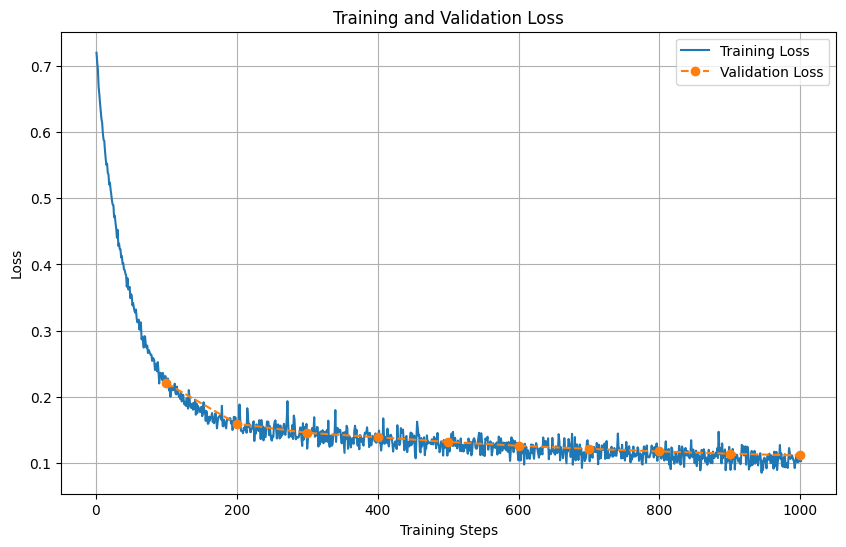

In [ ]:
plot_losses(train_losses, val_losses, eval_interval)

In [ ]:
def get_problem_topics(problem_title, df, dataset, model, threshold=0.5):
    """
    Given a LeetCode problem title, return the model-predicted topics and the actual topics.

    Arguments:
        problem_title (str): The title of the LeetCode problem.
        df (pd.DataFrame): The DataFrame from which the dataset was created, containing problem info.
        dataset (LeetCodeDataset): The dataset object that provides tokenized inputs and labels.
        model (nn.Module): The trained model that outputs logits for each topic.
        idx_to_topic (dict): A dictionary mapping from topic indices to topic names.
        device (str): 'cpu' or 'cuda', depending on available hardware.
        threshold (float): Threshold to convert predicted probabilities to binary (0/1).

    Returns:
        predicted_topics (list of str): The topics predicted by the model for the given problem.
        actual_topics (list of str): The actual annotated topics for the given problem.
    """
    # Find the problem index from the DataFrame
    matches = df.index[df['title'] == problem_title].tolist()
    if len(matches) == 0:
        raise ValueError(f"Problem titled '{problem_title}' not found in the DataFrame.")
    problem_idx = matches[0]

    # Get the input and label from the dataset
    (input_ids, attention_mask, difficulty), label = dataset[problem_idx]
    # Add batch dimension since we are predicting a single sample
    input_ids = input_ids.unsqueeze(0).to(device)
    attention_mask = attention_mask.unsqueeze(0).to(device)
    difficulty = difficulty.unsqueeze(0).to(device)

    model.to(device)
    model.eval()

    # Create idx_to_topic by inverting the dictionary
    idx_to_topic = {v: k for k, v in topic_to_idx.items()}

    with torch.no_grad():
        logits = model(input_ids, attention_mask, difficulty)  # shape: [1, num_topics]

    # Apply sigmoid to get probabilities
    probs = torch.sigmoid(logits).cpu().numpy()[0]
    # print(probs)

    # Convert probs to predicted labels
    predicted_indices = [i for i, p in enumerate(probs) if p > threshold]
    predicted_topics = [idx_to_topic[i] for i in predicted_indices]

    # Actual labels are in 'label' tensor
    label = label.cpu().numpy()
    actual_indices = [i for i, val in enumerate(label) if val > 0.5]
    actual_topics = [idx_to_topic[i] for i in actual_indices]

    return predicted_topics, actual_topics


In [ ]:
dataset = LeetCodeDataset(df, topic_to_idx)

In [ ]:
problem_name = "Longest Valid Parentheses"
predicted, actual = get_problem_topics(problem_name, df, dataset, model, threshold=0.3)
print("Predicted Topics:", predicted)
print("Actual Topics:", actual)

Predicted Topics: ['Dynamic Programming', 'String']
Actual Topics: ['Dynamic Programming', 'Stack', 'String']
